# CIFAR10 Image Classification (using a CNN)

## Purpose

The purpose of this notebook was to show the LeNet model used for the CIFAR10 dataset. Additionally, I wanted to show how tuning hyperparmeters can increase the accuracy and prevent overfitting. Obviously, better results can be achieved using different model architectures, but the purpose of this notebook was not to achive state-of-the-art results. It was to show a progression of improvement.


## Imports

In [0]:
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import PIL.ImageOps
from torch import nn
from torchvision import datasets, transforms
from tqdm import tqdm

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Preprocessing the image data from MNIST

Transformations used:

- ToTensor will convert the 32x32 numpy array with pixel brightness values ranging from 0-255 (which is the structure the images in the CIFAR10 dataset are currently in) to a float tensor with pixel brightness values ranging from 0-1

- Normalize will apply normalization to the pixel brightness values (subtract value from mean and then divide by the standard deviation). This makes convergence to minumum loss quicker. 



In [0]:
transform = transforms.Compose([
                               transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                               ]) # defining the transformations we want to make to the images before feeding them into our model
                                                          
training_dataset = datasets.CIFAR10(root = './data', train=True, download=True, transform=transform) 
validation_dataset = datasets.CIFAR10(root = './data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 100, shuffle=True) # create a dataloader to handle batching of the data. Note that we shuffle the data at each epoch to prevent the gradient descent process from getting stuck in a local minimum, we want it to reach the absolute minimum.
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Plotting the original training images

In [0]:
def image_convert(tensor): # all this function does is prepeare the images for plotting by changing them from tensors to numpy arrays and also reversing the transforms made when creating training_dataset
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

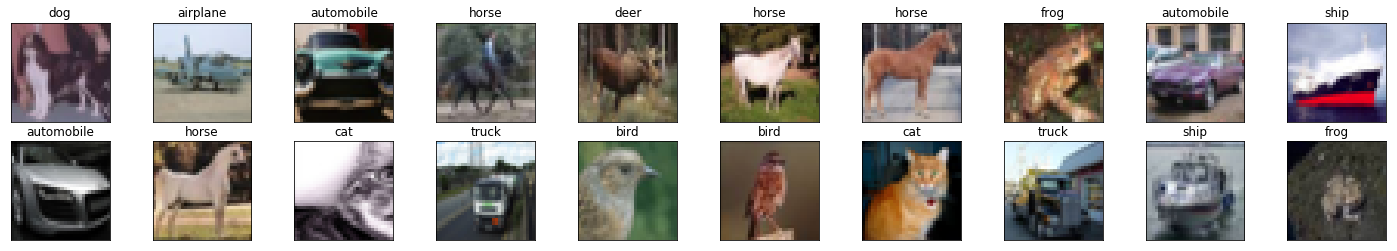

In [0]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  axis = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
  plt.imshow(image_convert(images[idx]))
  axis.set_title(classes[labels[idx].item()])
  

## Building the model

In [0]:
class LeNet(nn.Module): # note that LeNet is a tried and true CNN model architecture. It consists if 2 convolutional layers (each followed by a pooling layer) to extract the features. Then, after these layers it goes into 2 fully-connected hidden layers for classification.
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 20, 5, 1) # arguments here are input_channel size (3 since its an RGB image), output_channel size (# of desired features to be extracted), kernel_size, and stride, respectively
    self.conv2 = nn.Conv2d(20, 50, 5, 1) # second convolutional layer
    self.fc1 = nn.Linear(5*5*50, 500) # first fully connected layer. Input size is from the output of the images after passing through the convolutional (and pooling) layers. Output size is arbitrary.
    self.dropout1 = nn.Dropout(0.5) # defining a dropout layer (which will randomly turn off nodes during the training process) to decrease the chance of overfitting occuring
    self.fc2 = nn.Linear(500, 10) # since this is the second fully connected layer, the input size is simply the output size from the 1st fc layer. The output size is 10 since there are 10 potential classes (numbers 0-9) in the MNIST dataset
    
  def forward(self, x):
    x = F.relu(self.conv1(x)) # the input is passed through the first convolutional layer, and ReLu activation function is applied to introduce non-linearity
    x = F.max_pool2d(x, 2, 2) # this is the first pooling layer. The arguements are the images, followed by the kernel size (2), followed by the stride (2)
    x = F.relu(self.conv2(x)) # the input is passed through the second convolutional layer, and ReLu activation function is applied to introduce non-linearity
    x = F.max_pool2d(x, 2, 2) # this is the second pooling layer. The arguements are the images, followed by the kernel size (2), followed by the stride (2)
    x = x.view(-1, 5*5*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x) # note that we don't apply an activation function here since it will be implictly applied with the nn.CrossEntropyLoss loss function
    return x
    

In [0]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss() # we use Cross Entropy Loss for the loss function since it is a multi-class problem. Remember that this function also implicitly applies the log_softmax activation function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # We use Adam as our optimizer

## Training the model

In [0]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

def train():
  for e in tqdm(range(epochs)):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      _, preds = torch.max(outputs, 1) # gets the prediction of the model
      running_loss += loss.item()
      running_corrects += torch.sum(preds == labels.data) # counts the number of images classified correctly by comparing the prediction to the corresponding label

    else: # this block of code is executed after all of the iterations (end of an epoch)
      with torch.no_grad(): # this will set requires_grad = False for the tensors since no gradients need to be taken in this step. This is done to save memory. 
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels)
          
          _, val_preds = torch.max(val_outputs, 1) # gets the prediction of the model
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(val_preds == val_labels.data) # counts the number of images classified correctly by comparing the prediction to the corresponding label
        
      epoch_loss = running_loss/len(training_loader) # average loss for each epoch
      epoch_accuracy = running_corrects.float()/len(training_loader) # accuracy for each epoch
      running_loss_history.append(epoch_loss)
      running_corrects_history.append(epoch_accuracy)
      
      val_epoch_loss = val_running_loss/len(validation_loader) # average loss for each epoch
      val_epoch_accuracy = val_running_corrects.float()/len(validation_loader) # accuracy for each epoch
      val_running_loss_history.append(val_epoch_loss)
      val_running_corrects_history.append(val_epoch_accuracy)
      
      print("")
      print("Epoch #{}".format(e+1))
      print("Training loss: {:.4f}, Training Accuracy: {:.4f}".format(epoch_loss, epoch_accuracy.item()))
      print("Validation loss: {:.4f}, Validation Accuracy: {:.4f}".format(val_epoch_loss, val_epoch_accuracy.item()))

    

In [0]:
train()

  7%|▋         | 1/15 [00:13<03:09, 13.52s/it]


Epoch #1
Training loss: 1.8567, Training Accuracy: 32.8020
Validation loss: 1.6197, Validation Accuracy: 41.3300


 13%|█▎        | 2/15 [00:26<02:55, 13.50s/it]


Epoch #2
Training loss: 1.5455, Training Accuracy: 43.9840
Validation loss: 1.4828, Validation Accuracy: 46.8300


 20%|██        | 3/15 [00:40<02:42, 13.52s/it]


Epoch #3
Training loss: 1.4455, Training Accuracy: 47.9220
Validation loss: 1.4107, Validation Accuracy: 49.0500


 27%|██▋       | 4/15 [00:54<02:28, 13.51s/it]


Epoch #4
Training loss: 1.3780, Training Accuracy: 50.6120
Validation loss: 1.3507, Validation Accuracy: 51.2200


 33%|███▎      | 5/15 [01:07<02:15, 13.52s/it]


Epoch #5
Training loss: 1.3205, Training Accuracy: 52.7480
Validation loss: 1.3104, Validation Accuracy: 52.7000


 40%|████      | 6/15 [01:21<02:01, 13.50s/it]


Epoch #6
Training loss: 1.2738, Training Accuracy: 54.1880
Validation loss: 1.2662, Validation Accuracy: 54.3100


 47%|████▋     | 7/15 [01:34<01:47, 13.48s/it]


Epoch #7
Training loss: 1.2337, Training Accuracy: 56.0780
Validation loss: 1.2392, Validation Accuracy: 55.2500


 53%|█████▎    | 8/15 [01:47<01:34, 13.48s/it]


Epoch #8
Training loss: 1.1993, Training Accuracy: 57.2820
Validation loss: 1.2116, Validation Accuracy: 56.7600


 60%|██████    | 9/15 [02:01<01:20, 13.49s/it]


Epoch #9
Training loss: 1.1677, Training Accuracy: 58.5800
Validation loss: 1.1857, Validation Accuracy: 57.4200


 67%|██████▋   | 10/15 [02:14<01:07, 13.48s/it]


Epoch #10
Training loss: 1.1377, Training Accuracy: 59.8000
Validation loss: 1.1627, Validation Accuracy: 58.6700


 73%|███████▎  | 11/15 [02:28<00:53, 13.45s/it]


Epoch #11
Training loss: 1.1122, Training Accuracy: 60.6000
Validation loss: 1.1491, Validation Accuracy: 58.6100


 80%|████████  | 12/15 [02:41<00:40, 13.44s/it]


Epoch #12
Training loss: 1.0832, Training Accuracy: 61.7060
Validation loss: 1.1283, Validation Accuracy: 59.6000


 87%|████████▋ | 13/15 [02:55<00:26, 13.44s/it]


Epoch #13
Training loss: 1.0605, Training Accuracy: 62.6840
Validation loss: 1.1191, Validation Accuracy: 60.2500


 93%|█████████▎| 14/15 [03:08<00:13, 13.43s/it]


Epoch #14
Training loss: 1.0381, Training Accuracy: 63.4400
Validation loss: 1.1058, Validation Accuracy: 60.4300


100%|██████████| 15/15 [03:22<00:00, 13.46s/it]


Epoch #15
Training loss: 1.0181, Training Accuracy: 64.1860
Validation loss: 1.1170, Validation Accuracy: 60.1800


## Plotting (and analyzing) the results

In [0]:
def plot_losses():
  plt.plot(running_loss_history, label="Training loss")
  plt.plot(val_running_loss_history, label="Validation loss")
  plt.legend()

In [0]:
def plot_accuracy():
  plt.plot(running_corrects_history, label ="Training accuracy")
  plt.plot(val_running_corrects_history, label ="Validation accuracy")
  plt.legend()

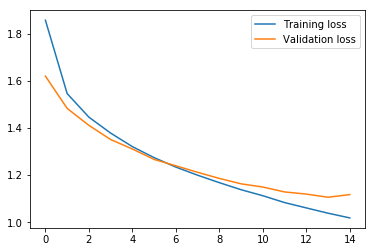

In [0]:
plot_losses()

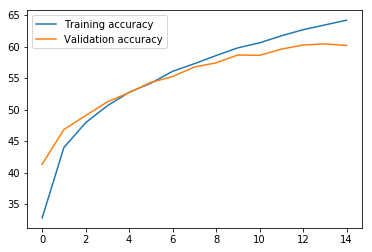

In [0]:
plot_accuracy()

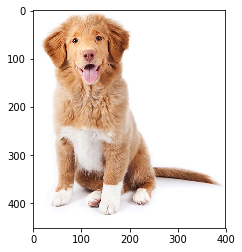

In [0]:
import requests
from PIL import Image

url = 'https://www.akc.org/wp-content/themes/akc/component-library/assets/img/welcome.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)

plt.imshow(img)

We must apply some preprocessing to this image so that it can be classified by our model:

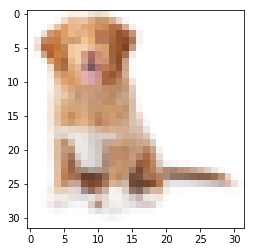

In [0]:
img = transform(img)
plt.imshow(image_convert(img)) # we have to convert the image back to a numpy array for plt.imshow to render the image

In [0]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1) # gets the prediction of the model
print("Prediction is: {}".format(classes[pred.item()]))

Prediction is: cat


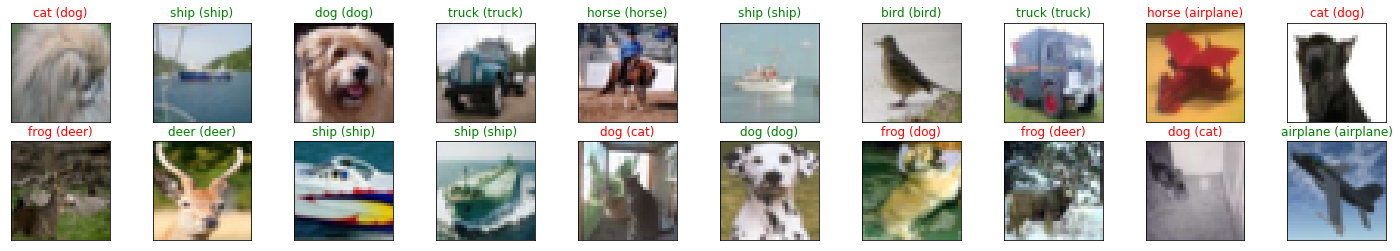

In [0]:
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(image_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

Clearly, the model is overfitting (since the validation loss and training loss are diverging). Also, it is clear that this model is not complicated enough to handle the CIFAR10 dataset (given its low accuracy and high loss). I am going to try to improve this model by tuning the hyperparameters, and if that doesn't help then I will create a new model architecture. 

## Tuning Hyperparameters 

In [0]:
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

model = LeNet().to(device)
criterion = nn.CrossEntropyLoss() # we use Cross Entropy Loss for the loss function since it is a multi-class problem. Remember that this function also implicitly applies the log_softmax activation function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # We use Adam as our optimizer
train()

  7%|▋         | 1/15 [00:13<03:08, 13.48s/it]


Epoch #1
Training loss: 1.5318, Training Accuracy: 44.3340
Validation loss: 1.2666, Validation Accuracy: 54.7500


 13%|█▎        | 2/15 [00:26<02:55, 13.47s/it]


Epoch #2
Training loss: 1.1742, Training Accuracy: 58.3320
Validation loss: 1.1114, Validation Accuracy: 61.0800


 20%|██        | 3/15 [00:40<02:41, 13.49s/it]


Epoch #3
Training loss: 1.0149, Training Accuracy: 64.1780
Validation loss: 1.0235, Validation Accuracy: 63.8700


 27%|██▋       | 4/15 [00:53<02:28, 13.49s/it]


Epoch #4
Training loss: 0.9169, Training Accuracy: 67.6480
Validation loss: 0.9438, Validation Accuracy: 67.1400


 33%|███▎      | 5/15 [01:07<02:15, 13.52s/it]


Epoch #5
Training loss: 0.8388, Training Accuracy: 70.7440
Validation loss: 0.9357, Validation Accuracy: 67.7600


 40%|████      | 6/15 [01:21<02:01, 13.52s/it]


Epoch #6
Training loss: 0.7709, Training Accuracy: 72.9080
Validation loss: 0.9094, Validation Accuracy: 69.0600


 47%|████▋     | 7/15 [01:34<01:48, 13.51s/it]


Epoch #7
Training loss: 0.7167, Training Accuracy: 74.7640
Validation loss: 0.9250, Validation Accuracy: 69.2200


 53%|█████▎    | 8/15 [01:47<01:34, 13.46s/it]


Epoch #8
Training loss: 0.6686, Training Accuracy: 76.5360
Validation loss: 0.9191, Validation Accuracy: 69.3200


 60%|██████    | 9/15 [02:01<01:20, 13.44s/it]


Epoch #9
Training loss: 0.6243, Training Accuracy: 77.8860
Validation loss: 0.9071, Validation Accuracy: 69.9900


 67%|██████▋   | 10/15 [02:14<01:07, 13.46s/it]


Epoch #10
Training loss: 0.5836, Training Accuracy: 79.3240
Validation loss: 0.9203, Validation Accuracy: 70.4600


 73%|███████▎  | 11/15 [02:28<00:53, 13.41s/it]


Epoch #11
Training loss: 0.5470, Training Accuracy: 80.6100
Validation loss: 0.9060, Validation Accuracy: 70.4500


 80%|████████  | 12/15 [02:41<00:40, 13.37s/it]


Epoch #12
Training loss: 0.5145, Training Accuracy: 81.7520
Validation loss: 0.9848, Validation Accuracy: 69.9200


 87%|████████▋ | 13/15 [02:54<00:26, 13.36s/it]


Epoch #13
Training loss: 0.4886, Training Accuracy: 82.4520
Validation loss: 0.9600, Validation Accuracy: 70.5300


 93%|█████████▎| 14/15 [03:07<00:13, 13.34s/it]


Epoch #14
Training loss: 0.4579, Training Accuracy: 83.7360
Validation loss: 0.9778, Validation Accuracy: 70.4600


100%|██████████| 15/15 [03:21<00:00, 13.32s/it]


Epoch #15
Training loss: 0.4284, Training Accuracy: 84.4760
Validation loss: 1.0246, Validation Accuracy: 70.4100


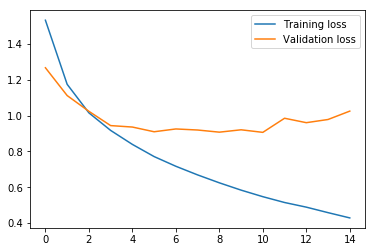

In [0]:
plot_losses()

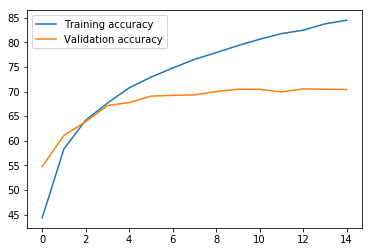

In [0]:
plot_accuracy()

Clearly the model is still overfitting. Let's try adding another convolutional layer (and pooling layer) and changing the input/output sizes on the current convolutional layers. Let's also change the kernel size from 5 to 3, and add padding to our current convolutional layers.

In [0]:
class LeNet(nn.Module): # note that LeNet is a tried and true CNN model architecture. It consists if 2 convolutional layers (each followed by a pooling layer) to extract the features. Then, after these layers it goes into 2 fully-connected hidden layers for classification.
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) # arguments here are input_channel size (3 since its an RGB image), output_channel size (# of desired features to be extracted), kernel_size, stride, and padding respectively
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1) # second convolutional layer
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1) # second convolutional layer
    self.fc1 = nn.Linear(4*4*64, 500) # first fully connected layer. Input size is from the output of the images after passing through the convolutional (and pooling) layers. Output size is arbitrary.
    self.dropout1 = nn.Dropout(0.5) # defining a dropout layer (which will randomly turn off nodes during the training process) to decrease the chance of overfitting occuring
    self.fc2 = nn.Linear(500, 10) # since this is the second fully connected layer, the input size is simply the output size from the 1st fc layer. The output size is 10 since there are 10 potential classes (numbers 0-9) in the MNIST dataset
    
  def forward(self, x):
    x = F.relu(self.conv1(x)) # the input is passed through the first convolutional layer, and ReLu activation function is applied to introduce non-linearity
    x = F.max_pool2d(x, 2, 2) # this is the first pooling layer. The arguements are the images, followed by the kernel size (2), followed by the stride (2)
    x = F.relu(self.conv2(x)) # the input is passed through the second convolutional layer, and ReLu activation function is applied to introduce non-linearity
    x = F.max_pool2d(x, 2, 2) # this is the second pooling layer. The arguements are the images, followed by the kernel size (2), followed by the stride (2)
    x = F.relu(self.conv3(x)) # the input is passed through the third convolutional layer, and ReLu activation function is applied to introduce non-linearity
    x = F.max_pool2d(x, 2, 2) # this is the third pooling layer. The arguements are the images, followed by the kernel size (2), followed by the stride (2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x) # note that we don't apply an activation function here since it will be implictly applied with the nn.CrossEntropyLoss loss function
    return x

In [0]:
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

model = LeNet().to(device)
criterion = nn.CrossEntropyLoss() # we use Cross Entropy Loss for the loss function since it is a multi-class problem. Remember that this function also implicitly applies the log_softmax activation function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # We use Adam as our optimizer
train()

  7%|▋         | 1/15 [00:14<03:22, 14.45s/it]


Epoch #1
Training loss: 1.5754, Training Accuracy: 42.5460
Validation loss: 1.3217, Validation Accuracy: 51.6200


 13%|█▎        | 2/15 [00:28<03:08, 14.47s/it]


Epoch #2
Training loss: 1.2240, Training Accuracy: 56.1040
Validation loss: 1.1428, Validation Accuracy: 58.4400


 20%|██        | 3/15 [00:43<02:53, 14.48s/it]


Epoch #3
Training loss: 1.0498, Training Accuracy: 62.7800
Validation loss: 1.0541, Validation Accuracy: 62.7500


 27%|██▋       | 4/15 [00:57<02:39, 14.46s/it]


Epoch #4
Training loss: 0.9374, Training Accuracy: 66.9740
Validation loss: 0.9506, Validation Accuracy: 66.6200


 33%|███▎      | 5/15 [01:12<02:24, 14.43s/it]


Epoch #5
Training loss: 0.8439, Training Accuracy: 70.2620
Validation loss: 0.9014, Validation Accuracy: 68.7600


 40%|████      | 6/15 [01:26<02:09, 14.44s/it]


Epoch #6
Training loss: 0.7734, Training Accuracy: 72.8160
Validation loss: 0.8696, Validation Accuracy: 70.2100


 47%|████▋     | 7/15 [01:41<01:55, 14.40s/it]


Epoch #7
Training loss: 0.7173, Training Accuracy: 74.8460
Validation loss: 0.8474, Validation Accuracy: 71.0700


 53%|█████▎    | 8/15 [01:55<01:40, 14.38s/it]


Epoch #8
Training loss: 0.6682, Training Accuracy: 76.3800
Validation loss: 0.8620, Validation Accuracy: 70.7400


 60%|██████    | 9/15 [02:09<01:26, 14.39s/it]


Epoch #9
Training loss: 0.6229, Training Accuracy: 78.1200
Validation loss: 0.8220, Validation Accuracy: 72.3500


 67%|██████▋   | 10/15 [02:24<01:11, 14.37s/it]


Epoch #10
Training loss: 0.5818, Training Accuracy: 79.3400
Validation loss: 0.8261, Validation Accuracy: 72.1900


 73%|███████▎  | 11/15 [02:38<00:57, 14.40s/it]


Epoch #11
Training loss: 0.5459, Training Accuracy: 80.7200
Validation loss: 0.8576, Validation Accuracy: 72.5000


 80%|████████  | 12/15 [02:52<00:43, 14.37s/it]


Epoch #12
Training loss: 0.5073, Training Accuracy: 81.9800
Validation loss: 0.8697, Validation Accuracy: 72.5200


 87%|████████▋ | 13/15 [03:07<00:28, 14.35s/it]


Epoch #13
Training loss: 0.4829, Training Accuracy: 82.7360
Validation loss: 0.8630, Validation Accuracy: 72.3900


 93%|█████████▎| 14/15 [03:21<00:14, 14.36s/it]


Epoch #14
Training loss: 0.4497, Training Accuracy: 84.1020
Validation loss: 0.9201, Validation Accuracy: 71.6500


100%|██████████| 15/15 [03:35<00:00, 14.38s/it]


Epoch #15
Training loss: 0.4236, Training Accuracy: 84.7760
Validation loss: 0.8653, Validation Accuracy: 73.5300


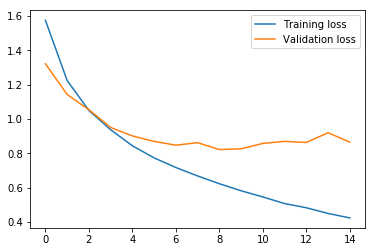

In [0]:
plot_losses()

Clearly, the model is still overfitting. To try and fix this issue we are going to try using data augmentation

## Using data augmentation to fix the overfitting issue

Data augmentation is when you take the existing training data and change it in random ways (such as roating the images and zooming in on them) to introduce more diversified data into your training set. This should help the model better generalize to new data. 

In [0]:
transform_train_augmented = transforms.Compose([
                               transforms.Resize((32,32)),
                               transforms.RandomHorizontalFlip(), # data augmentation
                               transforms.RandomRotation(10), # data augmentation
                               transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # data augmentation
                               transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # data augmentation
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                               ]) # defining the transformations we want to make to the images before feeding them into our model

training_dataset = datasets.CIFAR10(root = './data', train=True, download=True, transform=transform_train_augmented)
validation_dataset = datasets.CIFAR10(root = './data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 100, shuffle=True) # create a dataloader to handle batching of the data. Note that we shuffle the data at each epoch to prevent the gradient descent process from getting stuck in a local minimum, we want it to reach the absolute minimum.
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

model = LeNet().to(device)
criterion = nn.CrossEntropyLoss() # we use Cross Entropy Loss for the loss function since it is a multi-class problem. Remember that this function also implicitly applies the log_softmax activation function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # We use Adam as our optimizer
train()

  7%|▋         | 1/15 [00:32<07:36, 32.60s/it]


Epoch #1
Training loss: 1.6881, Training Accuracy: 37.9580
Validation loss: 1.4186, Validation Accuracy: 47.7800


 13%|█▎        | 2/15 [01:05<07:03, 32.57s/it]


Epoch #2
Training loss: 1.4000, Training Accuracy: 49.1620
Validation loss: 1.2651, Validation Accuracy: 54.9600


 20%|██        | 3/15 [01:37<06:30, 32.55s/it]


Epoch #3
Training loss: 1.2750, Training Accuracy: 54.3900
Validation loss: 1.1427, Validation Accuracy: 58.3800


 27%|██▋       | 4/15 [02:10<05:57, 32.54s/it]


Epoch #4
Training loss: 1.1877, Training Accuracy: 57.5900
Validation loss: 1.0804, Validation Accuracy: 61.7900


 33%|███▎      | 5/15 [02:42<05:24, 32.50s/it]


Epoch #5
Training loss: 1.1151, Training Accuracy: 60.4740
Validation loss: 1.0184, Validation Accuracy: 64.2600


 40%|████      | 6/15 [03:14<04:52, 32.48s/it]


Epoch #6
Training loss: 1.0605, Training Accuracy: 62.4960
Validation loss: 0.9813, Validation Accuracy: 65.3500


 47%|████▋     | 7/15 [03:47<04:19, 32.46s/it]


Epoch #7
Training loss: 1.0218, Training Accuracy: 63.8360
Validation loss: 0.9266, Validation Accuracy: 67.7600


 53%|█████▎    | 8/15 [04:19<03:47, 32.44s/it]


Epoch #8
Training loss: 0.9840, Training Accuracy: 65.2860
Validation loss: 0.9130, Validation Accuracy: 68.3700


 60%|██████    | 9/15 [04:52<03:14, 32.40s/it]


Epoch #9
Training loss: 0.9505, Training Accuracy: 66.7940
Validation loss: 0.8898, Validation Accuracy: 68.8600


 67%|██████▋   | 10/15 [05:24<02:41, 32.30s/it]


Epoch #10
Training loss: 0.9334, Training Accuracy: 67.3200
Validation loss: 0.9064, Validation Accuracy: 68.7900


 73%|███████▎  | 11/15 [05:56<02:08, 32.24s/it]


Epoch #11
Training loss: 0.9134, Training Accuracy: 67.7380
Validation loss: 0.8504, Validation Accuracy: 70.5500


 80%|████████  | 12/15 [06:28<01:36, 32.14s/it]


Epoch #12
Training loss: 0.8886, Training Accuracy: 68.8160
Validation loss: 0.8327, Validation Accuracy: 71.0500


 87%|████████▋ | 13/15 [06:59<01:03, 31.94s/it]


Epoch #13
Training loss: 0.8721, Training Accuracy: 69.4100
Validation loss: 0.8282, Validation Accuracy: 71.1800


 93%|█████████▎| 14/15 [07:31<00:31, 31.93s/it]


Epoch #14
Training loss: 0.8602, Training Accuracy: 70.0380
Validation loss: 0.8205, Validation Accuracy: 71.7000


100%|██████████| 15/15 [08:03<00:00, 31.89s/it]


Epoch #15
Training loss: 0.8354, Training Accuracy: 70.7400
Validation loss: 0.7878, Validation Accuracy: 72.6200


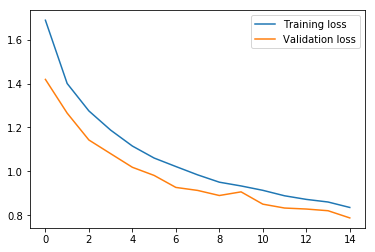

In [0]:
plot_losses()

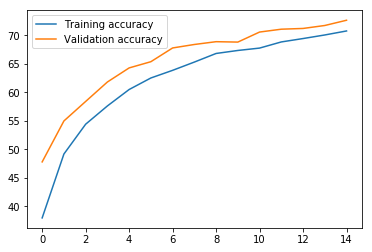

In [0]:
plot_accuracy()

Clearly, we have fixed the overfitting issue and have increased the accuracy of the model.

## Final Testing

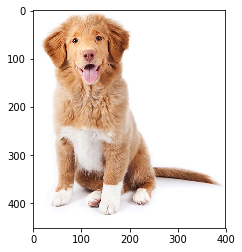

In [0]:
url = 'https://www.akc.org/wp-content/themes/akc/component-library/assets/img/welcome.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)

plt.imshow(img)

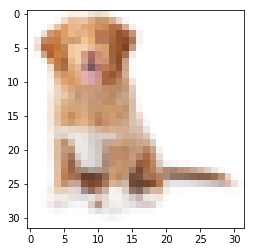

In [0]:
img = transform(img)
plt.imshow(image_convert(img)) # we have to convert the image back to a numpy array for plt.imshow to render the image

In [0]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1) # gets the prediction of the model
print("Prediction is: {}".format(classes[pred.item()]))

Prediction is: dog


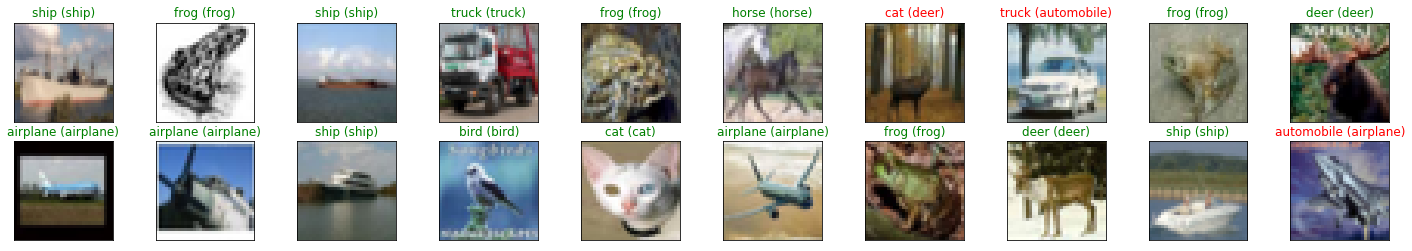

In [0]:
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(image_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))